In [1]:
from torch import nn , save , load
import torchvision
import torch
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [2]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision import datasets, transforms

transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(32, padding=4),         # Random crop with padding
    transforms.RandomHorizontalFlip(),            # Random horizontal flip
    transforms.ColorJitter(brightness=0.2),       # Random color jitter
    transforms.RandomRotation(10),                # Random rotation (degrees)
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# For test dataset, only normalization is applied
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

CIFAR_train = datasets.CIFAR10('dataTrain', train=True, download=True,transform=transform_train)

CIFAR_test = datasets.CIFAR10('dataTest', train=False, download=True, transform=transform_test)


print(CIFAR_train)
print('-----')
print(CIFAR_test)

100%|██████████| 170498071/170498071 [00:10<00:00, 15959315.06it/s]


Extracting dataTrain/cifar-10-python.tar.gz to dataTrain


100%|██████████| 170498071/170498071 [00:10<00:00, 15673592.75it/s]


Extracting dataTest/cifar-10-python.tar.gz to dataTest
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataTrain
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
-----
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataTest
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [4]:

model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1).to(device)
# print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 78.5MB/s]


In [5]:
batch_size = 64
num_epochs = 15
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
criterion.requires_grads = True
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=CIFAR_train,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=CIFAR_test,batch_size=batch_size,shuffle=False)


In [6]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Linear(2048, 10),
).to(device)

In [7]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    losses = []

    for i, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)
        # optimizer.require_grad = True


        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()
        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 0 is 0.47021


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 1 is 0.29679


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 2 is 0.24461


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 3 is 0.20579


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 4 is 0.18097


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 5 is 0.15454


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 6 is 0.14181


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 7 is 0.12331


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 8 is 0.11206


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 9 is 0.10098


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 10 is 0.09339


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 11 is 0.08345


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 12 is 0.08086


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 13 is 0.07667


  0%|          | 0/782 [00:00<?, ?it/s]

Cost at epoch 14 is 0.07161


In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} from {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()

check_accuracy(train_loader, model)

Got 49231 from 50000 with accuracy 98.46


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: >

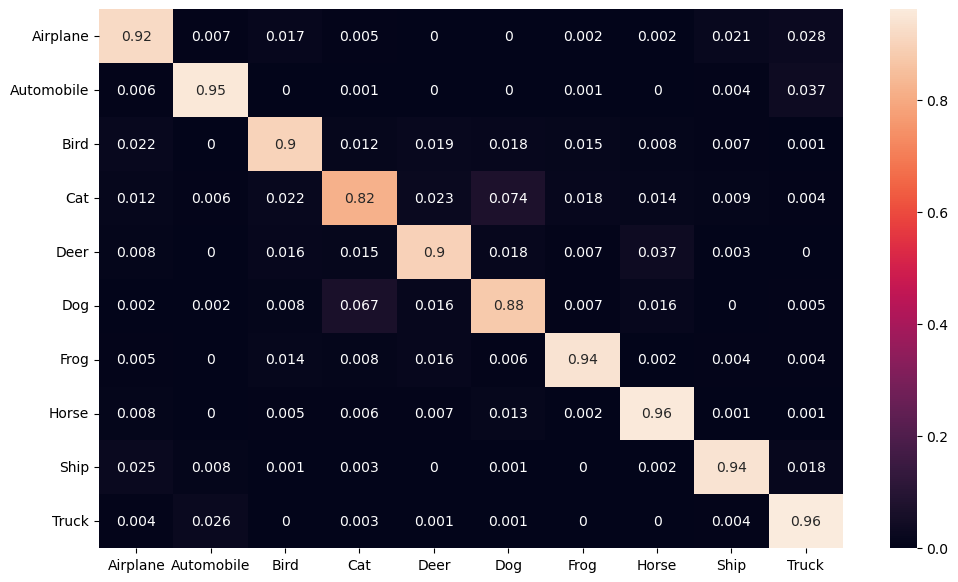

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
        #   inputs = inputs.reshape(inputs.shape[0], -1)

          output = model(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes
  classes = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
        'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [10]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix , classification_report
acc = accuracy_score(y_pred,y_true) * 100
report=classification_report(y_true, y_pred,target_names = classes)
print(f"Accuracy = {acc:.2f}%")
print("Classification Report: \n",report)

Accuracy = 91.59%
Classification Report: 
               precision    recall  f1-score   support

    Airplane       0.91      0.92      0.91      1000
  Automobile       0.95      0.95      0.95      1000
        Bird       0.92      0.90      0.91      1000
         Cat       0.87      0.82      0.84      1000
        Deer       0.92      0.90      0.91      1000
         Dog       0.87      0.88      0.87      1000
        Frog       0.95      0.94      0.94      1000
       Horse       0.92      0.96      0.94      1000
        Ship       0.95      0.94      0.94      1000
       Truck       0.91      0.96      0.93      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
torch.save(model,"RESNETBEST")